In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Inhibitory-Stabilised Network
Some initial conditions:

β = 1, 
τE = 20 ms, 
τI = 10 ms, 
V0 = −55 mV, 
Vrest = −70 mV, 
WEI = 0.65, 
WIE = 1.2,
WII = 0.5

## Network simulation

In [87]:
class EI_Network:
    def __init__(self):
        # neuron params
        self.beta = 1
        self.tau_E = 20
        self.tau_I = 10
        self.V_init = -55
        self.E_m = -70
        # connection weights
        self.W_EI = 0.65
        self.W_IE = 1.2
        self.W_II = 0.5
        self.W_EE = 0
        # results
        self.VI = np.array([])
        self.VE = np.array([])
    
    def phi(self, V):
        # 
        v = self.beta * (V - self.V_init)
        return v * (v > 0)
    
    def select_network(self, network_number):
        if network_number == 1:
            self.W_EE = 0.5
        elif network_number == 2:
            self.W_EE = 1.25

    def euler_simulate(self, N_t, dt, u_e, u_i):
        #
        u_e_size = len(u_e) if isinstance(u_e, list) else 1
        u_i_size = len(u_i) if isinstance(u_i, list) else 1
        n_neurons = max(u_e_size, u_i_size)
        
        # N_t+1 rows (N_t+init), n_neurons columns
        # Column is V of a SPECIFIC neuron OVER time
        # Row is V for ALL neurons AT a particular time
        VI = np.zeros([N_t+1, n_neurons]) + self.V_init
        VE = np.zeros([N_t+1, n_neurons]) + self.V_init
        
        for t in range(1, N_t+1):
            ve = VE[t-1]
            vi = VI[t-1]
            # excitatory
            dVE = -(ve - self.E_m)  + self.W_EE * self.phi(ve) - self.W_EI * self.phi(vi) + u_e[t]
            VE[t] = ve + dt * dVE / self.tau_E
            # inhibitory
            dVI = -(vi - self.E_m) + self.W_IE * self.phi(ve) - self.W_II * self.phi(vi) + u_i[t]
            VI[t] = vi + dt * dVI / self.tau_I

        self.VI = VI
        self.VE = VE
    
    def plot_V_and_Phi(self):
        # plot Vs and Phi(Vs)
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('EI Network')
        # V's
        axs[0].plot(self.VE, label='$V_E$')
        axs[0].plot(self.VI, label='$V_I$')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Voltage (mV)')
        axs[0].legend()
        axs[0].grid()
        axs[0].set_title('V vs Time')
        # Phi's
        axs[1].plot(self.phi(self.VE), label='$\phi(V_E)$')
        axs[1].plot(self.phi(self.VI), label='$\phi(V_I)$')
        axs[1].set_xlabel('Time (ms)')
        axs[1].set_ylabel('$\phi(V)$ $\delta$(mV)')
        axs[1].legend()
        axs[1].grid()
        axs[1].set_title('$\phi(V)$ vs Time')
        plt.show()

In [88]:
# instantiate the network
network = EI_Network()

## 2.
Consider Network 1 and set $u_E = 20, u_I = 20$. Simulate equations (1-3) for Nt = 500
time steps (i.e., 500 ms real time). Plot VE and VI and ϕ(VE ), ϕ(VI ) as a function of time.
Comment on what you observe - how do the V terms differ from their ϕ(V ) counterparts and
how does this relate to their biological interpretation

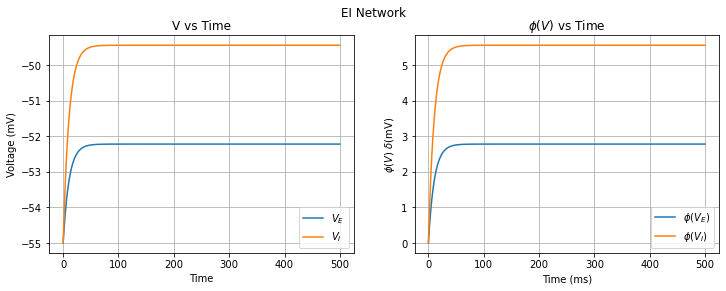

In [89]:
# setup
network.select_network(1)
Nt = 500
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
# simulate
network.euler_simulate(Nt, dt, u_E, u_I)
# plot Vs and Phi(Vs)
network.plot_V_and_Phi()


### Comment:


## 3. 
Repeat this simulation, this time:
- increasing uI after 500 time steps; and 
- simulating for a further 500 time steps at the new value 
- (Nt = 1000 in total, with 
- $u_I$ = 20 for the first 500 steps and $u_I$ = 26 for the second 500 steps). 

Plot VE , VI and ϕ(VE ), ϕ(VI ) as a function of
time. 

How do the E and I populations respond to the increase in $u_I$ - are these results in line
with intuition (justify your answer)?

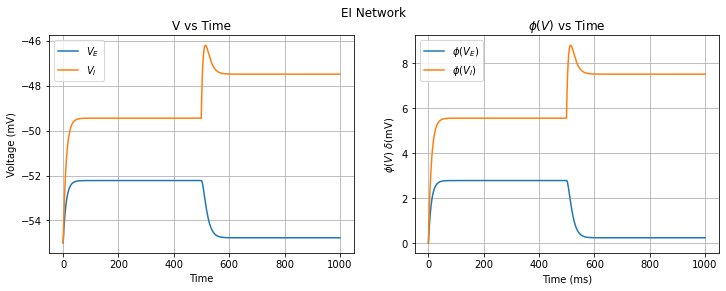

In [90]:
# setup
Nt = 1000
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
u_I[500:] = 26
# simulate
network.euler_simulate(Nt, dt, u_E, u_I)
# plot Vs and Phi(Vs)
network.plot_V_and_Phi()

### Comment:


## 4.
Now perform the simulation of question 3 for Network 2. Plot the results as before. 

How do the results differ from Network 1? Why is the change in VI and ϕ(VI ) following increased
uI in Network 2 considered “paradoxical”

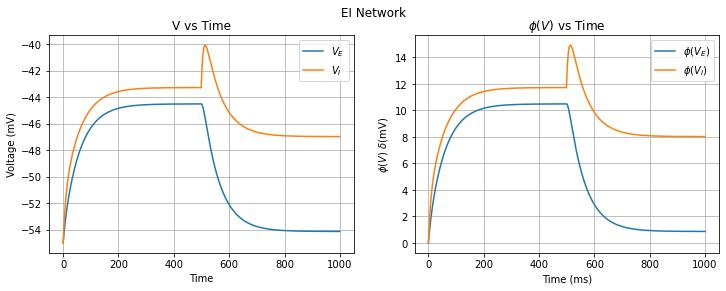

In [91]:
network.select_network(2)
# setup
Nt = 1000
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
u_I[500:] = 26
# simulate
network.euler_simulate(Nt, dt, u_E, u_I)
# plot Vs and Phi(Vs)
network.plot_V_and_Phi()

### Comment:


## 5. 
Repeat the simulation of questions 3 and 4, but this time increase uE rather than uI . Plot
VE and VI and ϕ(VE ), ϕ(VI ) as a function of time for Networks 1 and 2. What happens if
you clamp VI to remain constant when you increase uE . How the two networks differ? How
do you interpret these results?

### Comment

## 6.
A network is called “inhibitory-stabilised” if the excitatory subnetwork is unstable in isolation,
but the full excitatory-inhibitory network is stable. Based on the above simulations, can
you speculate on a relationship between inhibitory-stabilisation and paradoxical inhibition?
Explain your reasoning

### Comment:


## 7. 
Why are the above simulations not sufficient to demonstrate a general relationship between
paradoxical inhibition and inhibitory-stabilisation? How would you go about trying to find
out if this relationship holds more generally

### Comment

## 8. 
Assuming that this general relationship does hold within the model defined by equations
(1)-(3), suggest an experiment to test whether networks in the brain are in the inhibitory-
stabilised regime. Are there any caveats in this modelling approach that might limit your
confidence in making experimental predictions in this way?

### Comment